In [1]:
import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from package import euklid as eu
from pandas_datareader import data as pdr
from sklearn.model_selection import train_test_split
import talib

from keras.models import Sequential
from keras.layers import Dense, Dropout,BatchNormalization
from tensorflow.keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras import optimizers
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

# Import data

In [2]:
stocks = ["GC=F"]
start = datetime.datetime(2000,8,23)
end = datetime.datetime(2022,4,1)

yahoo_df = pdr.DataReader(stocks, 'yahoo',start,end)
yahoo_df = yahoo_df.droplevel(level = 1, axis = 1)
yahoo_df.tail()

Attributes    Adj Close        Close         High          Low         Open  \
Date                                                                          
2022-03-28  1939.599976  1939.599976  1939.599976  1932.599976  1932.599976   
2022-03-29  1912.000000  1912.000000  1912.000000  1893.500000  1893.500000   
2022-03-30  1933.500000  1933.500000  1937.000000  1914.500000  1918.400024   
2022-03-31  1949.199951  1949.199951  1949.900024  1919.099976  1933.500000   
2022-04-01  1919.099976  1919.099976  1938.000000  1917.000000  1935.000000   

Attributes    Volume  
Date                  
2022-03-28       7.0  
2022-03-29  128051.0  
2022-03-30   17765.0  
2022-03-31    3617.0  
2022-04-01    1016.0

# Add some indicators

In [3]:
# Add indicators
yahoo_df['vwap'] = eu.vwap(yahoo_df['Close'], yahoo_df['Volume'])
yahoo_df['SO'] = eu.Stochastic_Oscillator(yahoo_df['Close'])
yahoo_df['RSI_1'] = eu.rsi(yahoo_df['Close'],1)
yahoo_df['RSI_2'] = eu.rsi(yahoo_df['Close'],2)
yahoo_df['RSI_3'] = eu.rsi(yahoo_df['Close'],3)
yahoo_df['RSI_14'] = eu.rsi(yahoo_df['Close'],14)
yahoo_df['1 Day ROI']=eu.ROI(yahoo_df,1)
yahoo_df['2 Day ROI']=eu.ROI(yahoo_df,2)
yahoo_df['3 Day ROI']=eu.ROI(yahoo_df,3)
eu.macd(yahoo_df,yahoo_df['Close'])

# Select valid data
yahoo_df = yahoo_df[35:]

In [4]:
yahoo_df.columns

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'vwap', 'SO',
       'RSI_1', 'RSI_2', 'RSI_3', 'RSI_14', '1 Day ROI', '2 Day ROI',
       '3 Day ROI', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9'],
      dtype='object', name='Attributes')

# Normalize the price

In [5]:
days_ahead = 1
differenced = (yahoo_df['Close'] - yahoo_df['Close'].shift(days_ahead))/(yahoo_df['Close'].shift(days_ahead))[days_ahead:]
previous_differenced = differenced.shift(1)
yahoo_df["Previous_differenced"] = previous_differenced
yahoo_df["Differenced"] = differenced
yahoo_df=yahoo_df.dropna()
#yahoo_df = yahoo_df[days_ahead+1:]
yahoo_df.columns

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'vwap', 'SO',
       'RSI_1', 'RSI_2', 'RSI_3', 'RSI_14', '1 Day ROI', '2 Day ROI',
       '3 Day ROI', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
       'Previous_differenced', 'Differenced'],
      dtype='object', name='Attributes')

<AxesSubplot:xlabel='Date'>

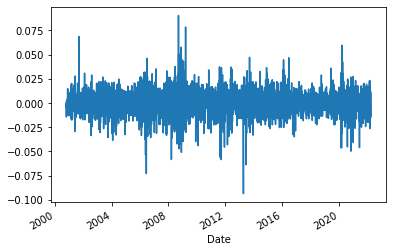

In [6]:
price = yahoo_df['Differenced'] 
price.plot()

In [7]:
yahoo_df.columns

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'vwap', 'SO',
       'RSI_1', 'RSI_2', 'RSI_3', 'RSI_14', '1 Day ROI', '2 Day ROI',
       '3 Day ROI', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
       'Previous_differenced', 'Differenced'],
      dtype='object', name='Attributes')

In [8]:
close = yahoo_df['Close']
yahoo_df = yahoo_df[[  'SO',
                       'RSI_1', 'RSI_2', 'RSI_3', 'RSI_14', '1 Day ROI', '2 Day ROI',
                       '3 Day ROI', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
                     "Previous_differenced",
                    "Differenced"]]
yahoo_df = yahoo_df.dropna()
yahoo_df

Attributes         SO      RSI_1      RSI_2      RSI_3     RSI_14 1 Day ROI  \
Date                                                                          
2000-10-23  11.267854  30.446669  35.747327  38.846404  55.915284 -0.004056   
2000-10-24  11.267854  30.446669  35.747327  38.846404  55.915284       0.0   
2000-10-25   0.000000   3.422183   9.643979  15.965978  47.708551 -0.014439   
2000-10-26   0.000000   2.149960   7.064592  12.653528  45.332279 -0.004884   
2000-10-27   0.000000   1.671867   6.120227  11.436740  44.420546 -0.001888   
...               ...        ...        ...        ...        ...       ...   
2022-03-28  23.921258  30.981571  42.557343  45.748319  52.634477 -0.007268   
2022-03-29   4.439513  10.305309  21.668710  28.461218  47.566525  -0.01423   
2022-03-30  28.301894  56.026595  50.219402  48.624845  51.466791  0.011245   
2022-03-31  55.153920  74.792545  64.423080  59.687622  54.135988   0.00812   
2022-04-01  20.708919  28.369648  35.386796  38.496976  48.640904 -0.015442   

Attributes 2 Day ROI 3 Day ROI  MACD_12_26_9  MACDh_12_26_9  MACDs_12_26_9  \
Date                                                                         
2000-10-23       0.0  -0.00074     -0.746043      -0.067572      -0.678471   
2000-10-24 -0.004056       0.0     -0.785659      -0.085750      -0.699909   
2000-10-25 -0.014439 -0.018437     -1.118855      -0.335157      -0.783698   
2000-10-26 -0.019252 -0.019252     -1.470860      -0.549729      -0.921130   
2000-10-27 -0.006762 -0.021103     -1.769771      -0.678913      -1.090859   
...              ...       ...           ...            ...            ...   
2022-03-28 -0.011215  0.001549     13.285872      -5.422509      18.708381   
2022-03-29 -0.021394 -0.025285      9.818518      -7.111890      16.930409   
2022-03-30 -0.003145  -0.01039      8.705138      -6.580216      15.285355   
2022-03-31  0.019456  0.004949      8.986046      -5.039447      14.025493   
2022-04-01 -0.007448  0.003713      6.702587      -5.858324      12.560912   

Attributes  Previous_differenced  Differenced  
Date                                           
2000-10-23              0.004073    -0.004056  
2000-10-24             -0.004056     0.000000  
2000-10-25              0.000000    -0.014439  
2000-10-26             -0.014439    -0.004884  
2000-10-27             -0.004884    -0.001888  
...                          ...          ...  
2022-03-28             -0.003976    -0.007268  
2022-03-29             -0.007268    -0.014230  
2022-03-30             -0.014230     0.011245  
2022-03-31              0.011245     0.008120  
2022-04-01              0.008120    -0.015442  

[5376 rows x 13 columns]

In [9]:
# convert series to supervised learning
values = yahoo_df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
values

array([[ 1.12678537e+01,  3.04466686e+01,  3.57473259e+01, ...,
        -6.78471327e-01,  4.07258840e-03, -4.05606953e-03],
       [ 1.12678537e+01,  3.04466686e+01,  3.57473259e+01, ...,
        -6.99908912e-01, -4.05606953e-03,  0.00000000e+00],
       [ 0.00000000e+00,  3.42218328e+00,  9.64397907e+00, ...,
        -7.83698082e-01,  0.00000000e+00, -1.44390734e-02],
       ...,
       [ 2.83018951e+01,  5.60265961e+01,  5.02194023e+01, ...,
         1.52853546e+01, -1.42297260e-02,  1.12447701e-02],
       [ 5.51539192e+01,  7.47925415e+01,  6.44230804e+01, ...,
         1.40254927e+01,  1.12447701e-02,  8.11996404e-03],
       [ 2.07089195e+01,  2.83696480e+01,  3.53867950e+01, ...,
         1.25609121e+01,  8.11996404e-03, -1.54422205e-02]], dtype=float32)

# Train, test, val

In [10]:
X =  yahoo_df[[  'SO',
                       'RSI_1', 'RSI_2', 'RSI_3', 'RSI_14', '1 Day ROI', '2 Day ROI',
                       '3 Day ROI', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
                     "Previous_differenced",
                    "Differenced"]]

y = yahoo_df["Differenced"]

In [11]:
# Split in 80/20 the dataframe
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.20,shuffle=False)
close_train, close_test = train_test_split(close,test_size = 0.20, shuffle=False)

close_train, close_test = list(close_train), list(close_test) 


In [12]:

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [13]:
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

y_train = y_train.values
y_test = y_test.values
print(X_train.shape)
print(y_train.shape)

(4300, 1, 13)
(4300,)


# LSTM

In [14]:
model = Sequential()
model.add(LSTM(75, return_sequences=False))
model.add(Dropout(0.2))
#model.add(Dense(40))
model.add(Dense(1))

In [15]:
# Set early stopping monitor so the model stops training when it won't improve anymore
esm = EarlyStopping(monitor = 'loss', patience = 70)
# Set the optimizer
opt = tf.optimizers.SGD(learning_rate = 0.001)
#design network
batch_size = int(round(X_train.shape[0]*0.1))
# fit network
model.compile(loss='mae', optimizer=opt)
history = model.fit(X_train, y_train, epochs=2000, batch_size= batch_size, verbose=1,
    shuffle=False, validation_split=0.10)

Epoch 1/2000
9/9 [==============================] - 8s 398ms/step - loss: 0.4108 - val_loss: 0.1912
Epoch 2/2000
9/9 [==============================] - 2s 217ms/step - loss: 0.2778 - val_loss: 0.1396
Epoch 3/2000
9/9 [==============================] - 2s 258ms/step - loss: 0.2548 - val_loss: 0.1223
Epoch 4/2000
9/9 [==============================] - 2s 218ms/step - loss: 0.2468 - val_loss: 0.1119
Epoch 5/2000
9/9 [==============================] - 1s 71ms/step - loss: 0.2426 - val_loss: 0.1051
Epoch 6/2000
9/9 [==============================] - 0s 27ms/step - loss: 0.2385 - val_loss: 0.1012
Epoch 7/2000
9/9 [==============================] - 0s 37ms/step - loss: 0.2312 - val_loss: 0.0986
Epoch 8/2000
9/9 [==============================] - 0s 24ms/step - loss: 0.2285 - val_loss: 0.0966
Epoch 9/2000
9/9 [==============================] - 0s 18ms/step - loss: 0.2263 - val_loss: 0.0951
Epoch 10/2000
9/9 [==============================] - 0s 17ms/step - loss: 0.2266 - val_loss: 0.0920
Epoch

Epoch 83/2000
9/9 [==============================] - 0s 28ms/step - loss: 0.0806 - val_loss: 0.0300
Epoch 84/2000
9/9 [==============================] - 0s 40ms/step - loss: 0.0797 - val_loss: 0.0297
Epoch 85/2000
9/9 [==============================] - 0s 47ms/step - loss: 0.0783 - val_loss: 0.0293
Epoch 86/2000
9/9 [==============================] - 0s 37ms/step - loss: 0.0779 - val_loss: 0.0288
Epoch 87/2000
9/9 [==============================] - 0s 33ms/step - loss: 0.0757 - val_loss: 0.0284
Epoch 88/2000
9/9 [==============================] - 0s 37ms/step - loss: 0.0752 - val_loss: 0.0280
Epoch 89/2000
9/9 [==============================] - 0s 48ms/step - loss: 0.0759 - val_loss: 0.0278
Epoch 90/2000
9/9 [==============================] - 0s 28ms/step - loss: 0.0739 - val_loss: 0.0276
Epoch 91/2000
9/9 [==============================] - 0s 24ms/step - loss: 0.0742 - val_loss: 0.0275
Epoch 92/2000
9/9 [==============================] - 0s 27ms/step - loss: 0.0723 - val_loss: 0.0272


9/9 [==============================] - 0s 45ms/step - loss: 0.0184 - val_loss: 0.0112
Epoch 246/2000
9/9 [==============================] - 0s 25ms/step - loss: 0.0177 - val_loss: 0.0111
Epoch 247/2000
9/9 [==============================] - 0s 45ms/step - loss: 0.0185 - val_loss: 0.0110
Epoch 248/2000
9/9 [==============================] - 0s 28ms/step - loss: 0.0180 - val_loss: 0.0110
Epoch 249/2000
9/9 [==============================] - 0s 33ms/step - loss: 0.0173 - val_loss: 0.0111
Epoch 250/2000
9/9 [==============================] - 0s 20ms/step - loss: 0.0184 - val_loss: 0.0110
Epoch 251/2000
9/9 [==============================] - 0s 27ms/step - loss: 0.0181 - val_loss: 0.0109
Epoch 252/2000
9/9 [==============================] - 0s 31ms/step - loss: 0.0175 - val_loss: 0.0110
Epoch 253/2000
9/9 [==============================] - 0s 31ms/step - loss: 0.0176 - val_loss: 0.0108
Epoch 254/2000
9/9 [==============================] - 0s 23ms/step - loss: 0.0177 - val_loss: 0.0109
Epoch

9/9 [==============================] - 0s 43ms/step - loss: 0.0131 - val_loss: 0.0081
Epoch 408/2000
9/9 [==============================] - 0s 30ms/step - loss: 0.0131 - val_loss: 0.0081
Epoch 409/2000
9/9 [==============================] - 0s 34ms/step - loss: 0.0128 - val_loss: 0.0080
Epoch 410/2000
9/9 [==============================] - 0s 25ms/step - loss: 0.0129 - val_loss: 0.0080
Epoch 411/2000
9/9 [==============================] - 0s 27ms/step - loss: 0.0129 - val_loss: 0.0080
Epoch 412/2000
9/9 [==============================] - 0s 21ms/step - loss: 0.0129 - val_loss: 0.0080
Epoch 413/2000
9/9 [==============================] - 0s 31ms/step - loss: 0.0123 - val_loss: 0.0081
Epoch 414/2000
9/9 [==============================] - 0s 19ms/step - loss: 0.0126 - val_loss: 0.0080
Epoch 415/2000
9/9 [==============================] - 0s 25ms/step - loss: 0.0127 - val_loss: 0.0079
Epoch 416/2000
9/9 [==============================] - 0s 21ms/step - loss: 0.0127 - val_loss: 0.0080
Epoch

9/9 [==============================] - 0s 31ms/step - loss: 0.0109 - val_loss: 0.0066
Epoch 570/2000
9/9 [==============================] - 0s 30ms/step - loss: 0.0109 - val_loss: 0.0066
Epoch 571/2000
9/9 [==============================] - 0s 27ms/step - loss: 0.0108 - val_loss: 0.0066
Epoch 572/2000
9/9 [==============================] - 0s 28ms/step - loss: 0.0105 - val_loss: 0.0066
Epoch 573/2000
9/9 [==============================] - 0s 13ms/step - loss: 0.0108 - val_loss: 0.0066
Epoch 574/2000
9/9 [==============================] - 0s 16ms/step - loss: 0.0104 - val_loss: 0.0066
Epoch 575/2000
9/9 [==============================] - 0s 14ms/step - loss: 0.0107 - val_loss: 0.0066
Epoch 576/2000
9/9 [==============================] - 0s 18ms/step - loss: 0.0108 - val_loss: 0.0067
Epoch 577/2000
9/9 [==============================] - 0s 12ms/step - loss: 0.0103 - val_loss: 0.0066
Epoch 578/2000
9/9 [==============================] - 0s 15ms/step - loss: 0.0106 - val_loss: 0.0067
Epoch

9/9 [==============================] - 0s 49ms/step - loss: 0.0095 - val_loss: 0.0061
Epoch 732/2000
9/9 [==============================] - 0s 44ms/step - loss: 0.0095 - val_loss: 0.0061
Epoch 733/2000
9/9 [==============================] - 0s 50ms/step - loss: 0.0095 - val_loss: 0.0061
Epoch 734/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.0093 - val_loss: 0.0060
Epoch 735/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.0095 - val_loss: 0.0060
Epoch 736/2000
9/9 [==============================] - 0s 45ms/step - loss: 0.0096 - val_loss: 0.0060
Epoch 737/2000
9/9 [==============================] - 0s 39ms/step - loss: 0.0095 - val_loss: 0.0059
Epoch 738/2000
9/9 [==============================] - 0s 42ms/step - loss: 0.0095 - val_loss: 0.0060
Epoch 739/2000
9/9 [==============================] - 0s 46ms/step - loss: 0.0097 - val_loss: 0.0060
Epoch 740/2000
9/9 [==============================] - 0s 40ms/step - loss: 0.0098 - val_loss: 0.0059
Epoch

9/9 [==============================] - 0s 26ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 894/2000
9/9 [==============================] - 0s 29ms/step - loss: 0.0087 - val_loss: 0.0056
Epoch 895/2000
9/9 [==============================] - 0s 26ms/step - loss: 0.0088 - val_loss: 0.0056
Epoch 896/2000
9/9 [==============================] - 0s 25ms/step - loss: 0.0086 - val_loss: 0.0056
Epoch 897/2000
9/9 [==============================] - 0s 29ms/step - loss: 0.0088 - val_loss: 0.0055
Epoch 898/2000
9/9 [==============================] - 0s 24ms/step - loss: 0.0088 - val_loss: 0.0055
Epoch 899/2000
9/9 [==============================] - 0s 31ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 900/2000
9/9 [==============================] - 0s 24ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 901/2000
9/9 [==============================] - 0s 37ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 902/2000
9/9 [==============================] - 0s 22ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch

9/9 [==============================] - 0s 16ms/step - loss: 0.0082 - val_loss: 0.0053
Epoch 1055/2000
9/9 [==============================] - 0s 14ms/step - loss: 0.0085 - val_loss: 0.0053
Epoch 1056/2000
9/9 [==============================] - 0s 37ms/step - loss: 0.0083 - val_loss: 0.0053
Epoch 1057/2000
9/9 [==============================] - 0s 30ms/step - loss: 0.0084 - val_loss: 0.0054
Epoch 1058/2000
9/9 [==============================] - 0s 16ms/step - loss: 0.0083 - val_loss: 0.0054
Epoch 1059/2000
9/9 [==============================] - 0s 32ms/step - loss: 0.0083 - val_loss: 0.0054
Epoch 1060/2000
9/9 [==============================] - 0s 21ms/step - loss: 0.0082 - val_loss: 0.0054
Epoch 1061/2000
9/9 [==============================] - 0s 39ms/step - loss: 0.0083 - val_loss: 0.0054
Epoch 1062/2000
9/9 [==============================] - 0s 29ms/step - loss: 0.0083 - val_loss: 0.0054
Epoch 1063/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.0080 - val_loss: 0.0

9/9 [==============================] - 0s 16ms/step - loss: 0.0081 - val_loss: 0.0052
Epoch 1215/2000
9/9 [==============================] - 0s 13ms/step - loss: 0.0080 - val_loss: 0.0052
Epoch 1216/2000
9/9 [==============================] - 0s 12ms/step - loss: 0.0080 - val_loss: 0.0052
Epoch 1217/2000
9/9 [==============================] - 0s 11ms/step - loss: 0.0079 - val_loss: 0.0052
Epoch 1218/2000
9/9 [==============================] - 0s 10ms/step - loss: 0.0081 - val_loss: 0.0052
Epoch 1219/2000
9/9 [==============================] - 0s 9ms/step - loss: 0.0080 - val_loss: 0.0052
Epoch 1220/2000
9/9 [==============================] - 0s 10ms/step - loss: 0.0080 - val_loss: 0.0052
Epoch 1221/2000
9/9 [==============================] - 0s 11ms/step - loss: 0.0081 - val_loss: 0.0052
Epoch 1222/2000
9/9 [==============================] - 0s 11ms/step - loss: 0.0080 - val_loss: 0.0052
Epoch 1223/2000
9/9 [==============================] - 0s 10ms/step - loss: 0.0079 - val_loss: 0.00

9/9 [==============================] - 0s 21ms/step - loss: 0.0077 - val_loss: 0.0050
Epoch 1375/2000
9/9 [==============================] - 0s 24ms/step - loss: 0.0076 - val_loss: 0.0050
Epoch 1376/2000
9/9 [==============================] - 0s 24ms/step - loss: 0.0079 - val_loss: 0.0050
Epoch 1377/2000
9/9 [==============================] - 0s 26ms/step - loss: 0.0078 - val_loss: 0.0050
Epoch 1378/2000
9/9 [==============================] - 0s 24ms/step - loss: 0.0078 - val_loss: 0.0051
Epoch 1379/2000
9/9 [==============================] - 0s 21ms/step - loss: 0.0077 - val_loss: 0.0050
Epoch 1380/2000
9/9 [==============================] - 0s 31ms/step - loss: 0.0078 - val_loss: 0.0050
Epoch 1381/2000
9/9 [==============================] - 0s 30ms/step - loss: 0.0077 - val_loss: 0.0050
Epoch 1382/2000
9/9 [==============================] - 0s 33ms/step - loss: 0.0077 - val_loss: 0.0050
Epoch 1383/2000
9/9 [==============================] - 0s 26ms/step - loss: 0.0077 - val_loss: 0.0

9/9 [==============================] - 0s 9ms/step - loss: 0.0075 - val_loss: 0.0049
Epoch 1535/2000
9/9 [==============================] - 0s 10ms/step - loss: 0.0074 - val_loss: 0.0049
Epoch 1536/2000
9/9 [==============================] - 0s 11ms/step - loss: 0.0074 - val_loss: 0.0049
Epoch 1537/2000
9/9 [==============================] - 0s 10ms/step - loss: 0.0074 - val_loss: 0.0049
Epoch 1538/2000
9/9 [==============================] - 0s 11ms/step - loss: 0.0074 - val_loss: 0.0049
Epoch 1539/2000
9/9 [==============================] - 0s 9ms/step - loss: 0.0073 - val_loss: 0.0049
Epoch 1540/2000
9/9 [==============================] - 0s 10ms/step - loss: 0.0075 - val_loss: 0.0049
Epoch 1541/2000
9/9 [==============================] - 0s 10ms/step - loss: 0.0074 - val_loss: 0.0049
Epoch 1542/2000
9/9 [==============================] - 0s 11ms/step - loss: 0.0075 - val_loss: 0.0049
Epoch 1543/2000
9/9 [==============================] - 0s 10ms/step - loss: 0.0075 - val_loss: 0.004

Epoch 1615/2000
9/9 [==============================] - 0s 10ms/step - loss: 0.0074 - val_loss: 0.0048
Epoch 1616/2000
9/9 [==============================] - 0s 10ms/step - loss: 0.0076 - val_loss: 0.0048
Epoch 1617/2000
9/9 [==============================] - 0s 10ms/step - loss: 0.0074 - val_loss: 0.0049
Epoch 1618/2000
9/9 [==============================] - 0s 9ms/step - loss: 0.0074 - val_loss: 0.0049
Epoch 1619/2000
9/9 [==============================] - 0s 9ms/step - loss: 0.0076 - val_loss: 0.0049
Epoch 1620/2000
9/9 [==============================] - 0s 9ms/step - loss: 0.0076 - val_loss: 0.0048
Epoch 1621/2000
9/9 [==============================] - 0s 9ms/step - loss: 0.0073 - val_loss: 0.0049
Epoch 1622/2000
9/9 [==============================] - 0s 9ms/step - loss: 0.0074 - val_loss: 0.0049
Epoch 1623/2000
9/9 [==============================] - 0s 9ms/step - loss: 0.0073 - val_loss: 0.0049
Epoch 1624/2000
9/9 [==============================] - 0s 9ms/step - loss: 0.0073 - val_

9/9 [==============================] - 0s 18ms/step - loss: 0.0071 - val_loss: 0.0048
Epoch 1776/2000
9/9 [==============================] - 0s 20ms/step - loss: 0.0072 - val_loss: 0.0048
Epoch 1777/2000
9/9 [==============================] - 0s 17ms/step - loss: 0.0072 - val_loss: 0.0048
Epoch 1778/2000
9/9 [==============================] - 0s 13ms/step - loss: 0.0073 - val_loss: 0.0048
Epoch 1779/2000
9/9 [==============================] - 0s 14ms/step - loss: 0.0071 - val_loss: 0.0048
Epoch 1780/2000
9/9 [==============================] - 0s 16ms/step - loss: 0.0071 - val_loss: 0.0048
Epoch 1781/2000
9/9 [==============================] - 0s 14ms/step - loss: 0.0073 - val_loss: 0.0048
Epoch 1782/2000
9/9 [==============================] - 0s 14ms/step - loss: 0.0073 - val_loss: 0.0048
Epoch 1783/2000
9/9 [==============================] - 0s 16ms/step - loss: 0.0072 - val_loss: 0.0048
Epoch 1784/2000
9/9 [==============================] - 0s 17ms/step - loss: 0.0072 - val_loss: 0.0

9/9 [==============================] - 0s 10ms/step - loss: 0.0070 - val_loss: 0.0047
Epoch 1936/2000
9/9 [==============================] - 0s 11ms/step - loss: 0.0071 - val_loss: 0.0047
Epoch 1937/2000
9/9 [==============================] - 0s 10ms/step - loss: 0.0071 - val_loss: 0.0047
Epoch 1938/2000
9/9 [==============================] - 0s 12ms/step - loss: 0.0071 - val_loss: 0.0047
Epoch 1939/2000
9/9 [==============================] - 0s 11ms/step - loss: 0.0070 - val_loss: 0.0047
Epoch 1940/2000
9/9 [==============================] - 0s 12ms/step - loss: 0.0071 - val_loss: 0.0046
Epoch 1941/2000
9/9 [==============================] - 0s 13ms/step - loss: 0.0071 - val_loss: 0.0047
Epoch 1942/2000
9/9 [==============================] - 0s 14ms/step - loss: 0.0072 - val_loss: 0.0047
Epoch 1943/2000
9/9 [==============================] - 0s 12ms/step - loss: 0.0070 - val_loss: 0.0047
Epoch 1944/2000
9/9 [==============================] - 0s 12ms/step - loss: 0.0070 - val_loss: 0.0

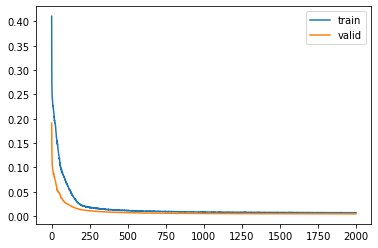

In [16]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()

# Prediction 

In [17]:
predict = model.predict(X_test)
predict = [float(predict[i]) for i in range(len(predict))]
pred = eu.scale_back_pct(predict, close_test)
updown_pred = eu.ud_pred(pred, close_test)

In [18]:
df = pd.DataFrame(updown_pred)
df["Close"] = list(close_test)
df["updown_pred"] = df.iloc[:,0]
df["updown_actual"] = eu.ud(close_test)
df["Scaled_pred"] = pred
df["Pred"] = predict
df = df.iloc[:,1:] 
print('Model Accuracy: ', (df["updown_pred"] == df["updown_actual"]).sum()/df.shape[0])



Model Accuracy:  0.8494423791821561


In [19]:
df

Close  updown_pred  updown_actual  Scaled_pred      Pred
0     1275.400024            1              1  1275.400024  0.008016
1     1284.099976            1              1  1283.893501  0.006659
2     1287.000000            1              1  1292.101956  0.006232
3     1294.099976            1              1  1293.550634  0.005090
4     1306.300049            1              1  1299.249830  0.003979
...           ...          ...            ...          ...       ...
1071  1939.599976            0              0  1942.678377 -0.005692
1072  1912.000000            0              0  1913.201923 -0.013610
1073  1933.500000            1              1  1919.022513  0.003673
1074  1949.199951            1              1  1946.057274  0.006495
1075  1919.099976            0              0  1939.382454 -0.005037

[1076 rows x 5 columns]

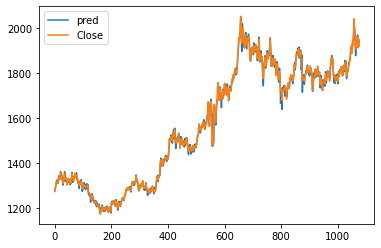

In [20]:
plt.plot(df['Scaled_pred'], label='pred')
plt.plot(df["Close"], label='Close')
plt.legend()
plt.show()

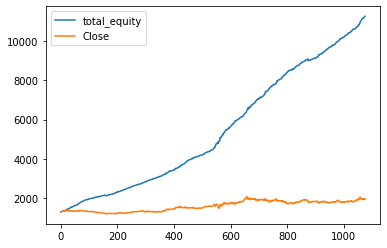

In [21]:
df_equity = pd.DataFrame()
df_equity["long_equity"] = eu.long_equity(df["updown_pred"], df["Close"])
df_equity["short_equity"] = eu.short_equity(df["updown_pred"], df["Close"])
df_equity["total_equity"] = eu.total_equity(df["updown_pred"], df["Close"])
df_equity["total_equity"].cumsum().plot()
df["Close"].plot()
plt.legend()